# Zeitreihenvorhersage mit Python

Eine Einführung in die Analyse und Vorhersage von Zeitreihendaten mit Python

## Machine Learning Pipeline

*   [Laden der Daten](#load)
*   [Analyse](#analysis)
*   [Vorbereiten der Daten](#prepare)
*   [Baseline](#baseline)
*   [Training](#train)
*   [Evaluation der Ergebnisse](#evaluate)

## Libraries

### Datenmanipulation
Folgende libraries wurden hauptsächlich für die Datenmanipulation verwendet. Zwischen den einzelnen bereitgestellten Formaten lässt sich leicht wechseln.

* [numpy](https://numpy.org/): Datenverarbeitung, benötigt für andere libraries
* [polars](https://pola.rs/): DataFrames zur Datenmanipulation mit intuitiver Syntax
* [pandas](https://pandas.pydata.org/): am weitesten verbreitet, DataFrames zur Datenmanipulation, gute Anbindung an Machine Learning libraries

### Machine Learning
Folgende libraries stellen Machine Learning Funktionen zur Verfügung.

* [scikit-learn](https://scikit-learn.org/stable/index.html): stellt verschieden Modelle zum Training zur Verfügung, vor allem aber nutze ich die bereitgestellten Vorverarbeitungsmethoden von dieser library, wie z.B. den One-Hot Encoder
* [tensorflow + keras](https://www.tensorflow.org/guide/keras/sequential_model): das Sequential Model von keras wird für das Training genutzt, es ist vielseitig einsetzbar, dadurch, dass man die Layer individuell aufbauen kann
* [darts](https://unit8co.github.io/darts/index.html): eine library mit vielen Funktionen für das Time Series Forecasting

## Imports

Für das Verarbeiten der Daten nutzen wir die library [numpy](https://numpy.org/). Die library [darts](https://unit8co.github.io/darts/index.html) hat viele benötigte Funktionen rund um das Thema Time Series Forecasting implementiert.

In [20]:
# !pip install darts

Numpy version>=2 makes problems when used with pandas, make sure it is downgraded to latest 1. version. Restart session after downgrading if it does not fix errors.

In [21]:
# !pip uninstall numpy

In [22]:
# !pip install numpy==1.26.4

In [23]:
import darts

<a name="load"></a>
## Laden der Daten

Im ersten Schritt geht es darum die vorhandenen Daten in einer Variable zu speichern. Dafür gibt es in Python verschiedene libraries (Codesammlungen), welche den Prozess vereinfachen. Ich verwende gerne [polars](https://pola.rs/), aufgrund seiner einfachen Handhabung. Weit verbreitet ist auch [pandas](https://pandas.pydata.org/). Beide speichern Daten in sogenannten DataFrames.

Als kleinen Beispieldatensatz haben wir eine Zeitreihe von Temperaturdaten, welche von einem Sensor mit einer bestimmten ID aufgenommen wurden.

In [24]:
import polars as pl
from datetime import datetime

df = pl.read_csv("preprocessing_mit_polars_testdata.csv", null_values="null")  # set "null" to null in dataframe
df

datetime,temperature,id
str,i64,i64
"""2021-07-08T15:30:00.000Z""",2149,38574
"""2021-07-08T16:00:00.000Z""",2195,38574
"""2021-07-08T16:30:00.000Z""",1942,38574
"""2021-07-08T17:31:00.000Z""",1993,38574
"""2021-07-08T18:31:00.000Z""",1869,38574
…,…,…
"""2021-07-25T02:30:00.000Z""",1628,38574
"""2021-07-25T03:00:00.000Z""",1635,38574
"""2021-07-25T03:30:00.000Z""",1651,38574


Informationen über das DataFrame können wir uns mit folgendem Befehl ausgeben lassen:

In [25]:
df.describe()

statistic,datetime,temperature,id
str,str,f64,f64
"""count""","""665""",659.0,665.0
"""null_count""","""0""",6.0,0.0
"""mean""",null,1943.775417,38574.0
"""std""",null,499.790282,0.0
"""min""","""2021-07-08T15:30:00.000Z""",1103.0,38574.0
"""25%""",null,1598.0,38574.0
"""50%""",null,1845.0,38574.0
"""75%""",null,2266.0,38574.0
"""max""","""2021-07-25T04:30:00.000Z""",8526.0,38574.0


Dabei sehen wir, dass 6 Werte fehlen, und der Mittelwert der Temperatur ungewöhnlich hoch ist. Wir müssen noch das Komma einfügen und können die ID Spalte ignorieren. Das alte DataFrame muss überschrieben werden, um Änderungen zu speichern.

In [26]:
df = df.select(
    pl.col("datetime"),
    pl.col("temperature") / 100  # ergänzen der Kommastellen
)
df

datetime,temperature
str,f64
"""2021-07-08T15:30:00.000Z""",21.49
"""2021-07-08T16:00:00.000Z""",21.95
"""2021-07-08T16:30:00.000Z""",19.42
"""2021-07-08T17:31:00.000Z""",19.93
"""2021-07-08T18:31:00.000Z""",18.69
…,…
"""2021-07-25T02:30:00.000Z""",16.28
"""2021-07-25T03:00:00.000Z""",16.35
"""2021-07-25T03:30:00.000Z""",16.51


Umwandeln des Datums von string in das datetime Format:

In [27]:
df = df.with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%dT%H:%M:%S%.fZ"))  # umwandeln in das richtige Format
df

datetime,temperature
datetime[μs],f64
2021-07-08 15:30:00,21.49
2021-07-08 16:00:00,21.95
2021-07-08 16:30:00,19.42
2021-07-08 17:31:00,19.93
2021-07-08 18:31:00,18.69
…,…
2021-07-25 02:30:00,16.28
2021-07-25 03:00:00,16.35
2021-07-25 03:30:00,16.51


<a name="analysis"></a>
## Analyse der Daten

In [28]:
df.describe()

statistic,datetime,temperature
str,str,f64
"""count""","""665""",659.0
"""null_count""","""0""",6.0
"""mean""","""2021-07-17 10:01:08.390977""",19.437754
"""std""",null,4.997903
"""min""","""2021-07-08 15:30:00""",11.03
"""25%""","""2021-07-13 05:00:00""",15.98
"""50%""","""2021-07-17 14:30:00""",18.45
"""75%""","""2021-07-21 12:30:00""",22.66
"""max""","""2021-07-25 04:30:00""",85.26


Eine erneute Analyse zeigt, dass der Maximalwert der Temperatur bei 85.26 liegt. Es muss fehlerhafte Werte in unserem Datensatz geben. Wir können die Daten mit polars ganz einfach plotten:

In [29]:
df.plot.scatter(x="datetime", y="temperature")

alt.Chart(...)

<a name="prepare"></a>
## Vorbereiten der Daten

### Outlier Filtering

Nach dem Plotten der Daten sehen wir, dass es Ausreißer in den Daten gibt. Diese können durch fehlerhafte Übertragungen entstanden sein. Wir filtern die Ausreißer, in dem wir Min- und Maxwerte setzen.

In [30]:
df = df.filter(
    (pl.col("temperature") < 50) & (pl.col("temperature") > -50)
)
df.plot.scatter(x="datetime", y="temperature")

alt.Chart(...)

### Ändern der Datenfrequenz

Unser Datensatz weißt pro Stunde manchmal mehrere Werte auf. Wir können über diese den Mittelwert nehmen.

In [31]:
df = df.group_by_dynamic("datetime", every="1h").agg(pl.col("temperature").mean())
df

datetime,temperature
datetime[μs],f64
2021-07-08 15:00:00,21.49
2021-07-08 16:00:00,20.685
2021-07-08 17:00:00,19.93
2021-07-08 18:00:00,18.69
2021-07-08 19:00:00,17.78
…,…
2021-07-25 00:00:00,17.22
2021-07-25 01:00:00,16.99
2021-07-25 02:00:00,16.455


### Missing Data

Für das finden von fehlenden Werten nehmen wir die darts library zur Hilfe. Mit dieser können wir eine Zeitreihe erstellen, und fehlende Werte linear interpolieren lassen.

<Axes: xlabel='datetime'>

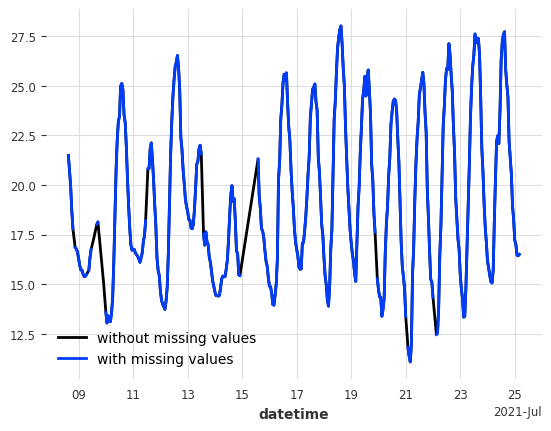

In [32]:
from darts.utils.missing_values import fill_missing_values

series = darts.TimeSeries.from_dataframe(df, time_col="datetime", freq="1h")
series_wo_missing_data = fill_missing_values(series)  # linear interpolation pandas
series_wo_missing_data.plot(label="without missing values")
series.plot(label="with missing values")

Transformieren der darts.TimeSeries zurück zu einem polars DataFrame

In [33]:
df = series_wo_missing_data.to_dataframe(backend="polars")
df

`time_as_index=True` is only supported with `backend="pandas"`, and will be ignored.


datetime,temperature
datetime[μs],f64
2021-07-08 15:00:00,21.49
2021-07-08 16:00:00,20.685
2021-07-08 17:00:00,19.93
2021-07-08 18:00:00,18.69
2021-07-08 19:00:00,17.78
…,…
2021-07-25 00:00:00,17.22
2021-07-25 01:00:00,16.99
2021-07-25 02:00:00,16.455


### Feature Engineering

Wir haben momentan kein anderes Feature außer unserer Zeitreihe. Im Realfall gibt es noch viele weiter Feature, wie zum Beispiel Addresse des Sensors oder weitere Umwelteinflüsse. Aus den Zeitdaten können wir uns neue Feature ableiten, zum Beispiel den Wochentag und die Stunde. Das Datum wird nämlich nicht als Feature mit eingegeben.

In [34]:
df = df.with_columns(
    pl.col("datetime").dt.weekday().alias("weekday"),
    pl.col("datetime").dt.hour().alias("hour")
    )
df

datetime,temperature,weekday,hour
datetime[μs],f64,i8,i8
2021-07-08 15:00:00,21.49,4,15
2021-07-08 16:00:00,20.685,4,16
2021-07-08 17:00:00,19.93,4,17
2021-07-08 18:00:00,18.69,4,18
2021-07-08 19:00:00,17.78,4,19
…,…,…,…
2021-07-25 00:00:00,17.22,7,0
2021-07-25 01:00:00,16.99,7,1
2021-07-25 02:00:00,16.455,7,2


### One-Hot Encoding

Die Feature weekday und hour sind momentan noch als Integer gespeichert. Das gibt dem Wert eine numerische Anordnung, obwohl ein Wochentag nicht "größer" als ein anderer ist. Deswegen will man kategorische Feature enkodieren, z.B. mit einem One-Hot Encoding. Dieses erstellt für jede mögliche Kategorie ein binäres Feature.

In [35]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

enc_cols = enc.fit_transform(df[["weekday"]]).toarray()
enc_cols_names = enc.get_feature_names_out()

df = pl.concat([df, pl.DataFrame(enc_cols, schema=list(enc_cols_names))], how="horizontal").drop("weekday")
df

datetime,temperature,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
datetime[μs],f64,i8,f64,f64,f64,f64,f64,f64,f64
2021-07-08 15:00:00,21.49,15,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-07-08 16:00:00,20.685,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-07-08 17:00:00,19.93,17,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-07-08 18:00:00,18.69,18,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-07-08 19:00:00,17.78,19,0.0,0.0,0.0,1.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…
2021-07-25 00:00:00,17.22,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-07-25 01:00:00,16.99,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-07-25 02:00:00,16.455,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Zyklische Feature

Die Stunde könnten wir auch One-hot encoden, aber auch zyklisch enkodieren. Dafür können wir den Sinus oder Kosinus verwenden.

In [36]:
import math

df = df.with_columns(((2*math.pi*pl.col("hour")) / 24).sin().alias("hour_sin"),
                ((2*math.pi*pl.col("hour")) / 24).cos().alias("hour_cos"))
df

datetime,temperature,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos
datetime[μs],f64,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-07-08 15:00:00,21.49,15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.707107,-0.707107
2021-07-08 16:00:00,20.685,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.866025,-0.5
2021-07-08 17:00:00,19.93,17,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.965926,-0.258819
2021-07-08 18:00:00,18.69,18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.8370e-16
2021-07-08 19:00:00,17.78,19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.965926,0.258819
…,…,…,…,…,…,…,…,…,…,…,…
2021-07-25 00:00:00,17.22,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2021-07-25 01:00:00,16.99,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.258819,0.965926
2021-07-25 02:00:00,16.455,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.866025


### Zusammenfassung

In [37]:
# daten laden
df = pl.read_csv("preprocessing_mit_polars_testdata.csv", null_values="null")  # set "null" to null in dataframe
# transformieren
df = df.select(
    pl.col("datetime"),
    pl.col("temperature") / 100  # ergänzen der Kommastellen
)
df = df.with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%dT%H:%M:%S%.fZ"))  # umwandeln in das richtige Format
# outlier filtern
df = df.filter(
    (pl.col("temperature") < 50) & (pl.col("temperature") > -50)
)
# Frequenz ändern
df = df.group_by_dynamic("datetime", every="1h").agg(pl.col("temperature").mean())
# missing data handling
series = darts.TimeSeries.from_dataframe(df, time_col="datetime", freq="1h")
series_wo_missing_data = fill_missing_values(series)  # linear interpolation pandas
df = series_wo_missing_data.to_dataframe(backend="polars")
# Feature hinzufügen
df = df.with_columns(
    pl.col("datetime").dt.weekday().alias("weekday"),
    pl.col("datetime").dt.hour().alias("hour")
    )
# one hot encoden
enc = OneHotEncoder()
enc_cols = enc.fit_transform(df[["weekday"]]).toarray()
enc_cols_names = enc.get_feature_names_out()
df = pl.concat([df, pl.DataFrame(enc_cols, schema=list(enc_cols_names))], how="horizontal").drop("weekday")
# zyklisch enkodieren
df = df.with_columns(((2*math.pi*pl.col("hour")) / 24).sin().alias("hour_sin"),
                ((2*math.pi*pl.col("hour")) / 24).cos().alias("hour_cos"))
df

`time_as_index=True` is only supported with `backend="pandas"`, and will be ignored.


datetime,temperature,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos
datetime[μs],f64,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-07-08 15:00:00,21.49,15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.707107,-0.707107
2021-07-08 16:00:00,20.685,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.866025,-0.5
2021-07-08 17:00:00,19.93,17,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.965926,-0.258819
2021-07-08 18:00:00,18.69,18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.8370e-16
2021-07-08 19:00:00,17.78,19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.965926,0.258819
…,…,…,…,…,…,…,…,…,…,…,…
2021-07-25 00:00:00,17.22,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2021-07-25 01:00:00,16.99,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.258819,0.965926
2021-07-25 02:00:00,16.455,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.866025


## Train-Test Split

Um unser Modell zu trainieren **und** zu testen, müssen wir den Datensatz in Trainings- und Testdatensatz aufteilen. Dabei muss sichergestellt sein, dass das Modelltraining die Testdaten nie zu sehen bekommt, um die Ergebnisse nicht zu verfälschen. Wir splitten die Daten zeitweise, wobei wir 80% der Zeit zum trainieren verwenden, den Rest für das Testen.

In [38]:
train_per = 0.8

In [39]:
n = len(df)
split_idx = train_per*n

df = df.with_row_index()
df_train = df.filter(pl.col("index") < split_idx).drop("index")
df_test = df.filter(pl.col("index") >= split_idx).drop("index")

df.with_columns(pl.col("index").is_in(df_train.with_row_index()["index"]).alias("train")).plot.line(x="datetime", y="temperature", color="train")

alt.Chart(...)

In [40]:
df = df.drop("index")

Das gleiche können wir auch mit Hilfe der darts library machen

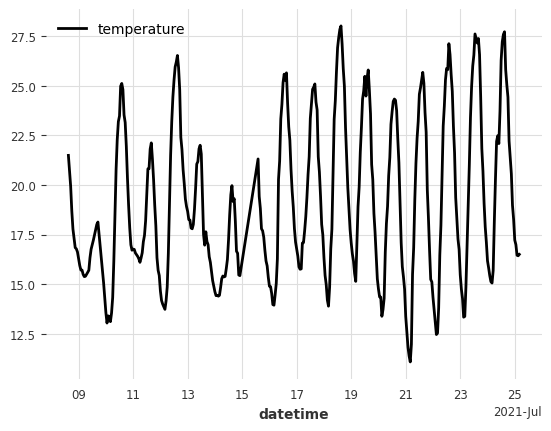

In [41]:
series = darts.TimeSeries.from_dataframe(df.select(["datetime", "temperature"]), time_col="datetime", freq="1h")
series.plot();

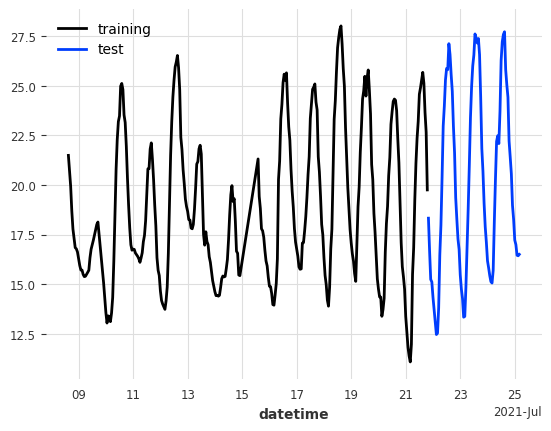

In [42]:
train, test = series.split_before(train_per)
train.plot(label="training")
test.plot(label="test");

<a name="baseline"></a>
## Baseline

Eine Baseline ist hilfreich um Modellergebnisse einzuordnen. In diesem Beispiel wird die naive Annahme getroffen, dass die nächsten 24h genaus so aussehen werden wie die letzten 24 Stunden.

/home/marja/anaconda3/envs/energy-forecast-wahl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


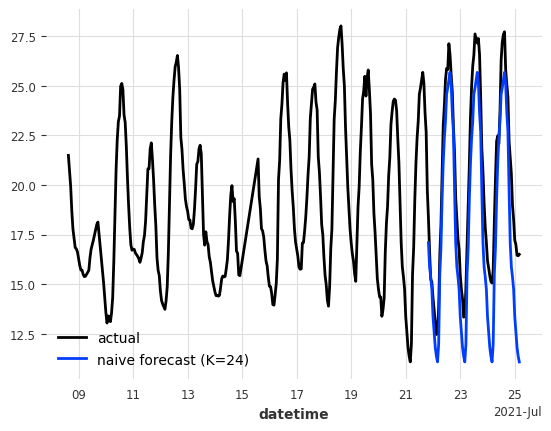

In [43]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=24)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test))

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=24)");

## Error Metrik

Um die Genauigkeit einer Vorhersage bewerten zu können, müssen wir eine Metrik festlegen. Typische Metriken für Regression, also numerische Vorhersagen, sind Mean Absolute Percentage Error ([MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)), Mean Absolute Error ([MAE](https://de.wikipedia.org/wiki/Mittlerer_absoluter_Fehler)), und Root Mean Squared Error ([RMSE](https://de.wikipedia.org/wiki/Standardfehler_der_Regression)). Der RMSE ist die Quadratwurzel des Mean Squared Errors ([MSE](https://de.wikipedia.org/wiki/Mittlere_quadratische_Abweichung)), welcher den durchschnittlichen quadratischen Fehler berechnet. Damit ist der RMSE in derselben Einheit wie die Zielvariable, liefert also einen interpretierbaren Fehler. Nachteil des MAE ist, dass sich negative und positive Fehler gegenseitig aufheben.

In [44]:
from darts.metrics import rmse, mse, mae

baseline_rmse = rmse(test, seasonal_forecast).round(2)
b_mse = mse(test, seasonal_forecast).round(2)
b_mae = mae(test, seasonal_forecast).round(2)

print(f"Baseline RMSE: {baseline_rmse}")
print(f"Baseline MSE: {b_mse}")
print(f"Baseline MAE: {b_mae}")

Baseline RMSE: 2.49
Baseline MSE: 6.2
Baseline MAE: 2.2


<a name="train"></a>
## Machine Learning



### Einfaches Neuronales Netz

#### Datenvorverarbeitung (Neuronales Netz)

Nachdem wir die Daten gesäubert, transformiert und ergänzt haben, muss die Struktur der Daten noch an das Training angepasst werden. Für das neuronale Netz brauchen wir als Input eine Liste von Featuren. Um die Zeitreiheninformation zu integrieren, erstellen wir Feature, welche jeweils die Temperatur zum Zeitpunkt t-k, k>0, beschreiben, um die Temperatur zum Zeitpunkt t vorherzusagen.

In [45]:
n_in = 7
cols, names = list(), list()
for i in range(n_in, 0, -1):
    cols.append(df["temperature"].shift(i))  # shift rows by i to get k-i temperature value
    names += [f'temp(t-{i})']

df = pl.concat([df, pl.DataFrame(cols, schema=names)], how="horizontal").drop_nans()  # drops first n_in rows
df

datetime,temperature,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,temp(t-7),temp(t-6),temp(t-5),temp(t-4),temp(t-3),temp(t-2),temp(t-1)
datetime[μs],f64,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-07-08 22:00:00,16.78,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,0.866025,21.49,20.685,19.93,18.69,17.78,17.31,16.84
2021-07-08 23:00:00,16.62,23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.258819,0.965926,20.685,19.93,18.69,17.78,17.31,16.84,16.78
2021-07-09 00:00:00,16.275,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,19.93,18.69,17.78,17.31,16.84,16.78,16.62
2021-07-09 01:00:00,15.94,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.258819,0.965926,18.69,17.78,17.31,16.84,16.78,16.62,16.275
2021-07-09 02:00:00,15.71,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.866025,17.78,17.31,16.84,16.78,16.62,16.275,15.94
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2021-07-25 00:00:00,17.22,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,25.055,24.425,22.21,21.405,20.56,18.97,18.26
2021-07-25 01:00:00,16.99,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.258819,0.965926,24.425,22.21,21.405,20.56,18.97,18.26,17.22
2021-07-25 02:00:00,16.455,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.866025,22.21,21.405,20.56,18.97,18.26,17.22,16.99


Nachdem wir neue Feature hinzugefügt haben, müssen wir die Daten noch einmal splitten.

In [46]:
n = len(df)
split_idx = train_per*n

# split the whole dataset into train and test
df = df.with_row_index()
df_train = df.filter(pl.col("index") < split_idx).drop("index")
df_test = df.filter(pl.col("index") >= split_idx).drop("index")
df = df.drop("index")

# select features to train on
train_features = names + list(enc_cols_names) + ["hour_sin", "hour_cos"]
X_train = df_train.select(train_features)
X_test = df_test.select(train_features)
print(X_train.shape)
print(X_test.shape)

(313, 16)
(78, 16)


In [47]:
# select target variable
target_variable = "temperature"
y_train = df_train[target_variable]
y_test = df_test[target_variable]
print(y_train.shape)
print(y_test.shape)

(313,)
(78,)


##### Scaling

Die meisten Machine Learning Modelle arbeiten besser auf skalierten Daten. Der StandardScaler von scikit-learn skaliert die Daten anhand des Mittelwerts und der Standardabweichung. Wir hätten die Daten vor dem Train-Test Split skalieren können, allerdings hätten wir dann Informationen aus dem Test set benutzt, um das Trainings set zu bearbeiten. Das sollte vermieden werden.

In [48]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()

other_features = list(enc_cols_names) + ["hour_sin", "hour_cos"]
X_train_scaled = pl.concat([
    pl.DataFrame(X_scaler.fit_transform(X_train[names])),
    X_train[other_features]
    ], how="horizontal")
X_test_scaled = pl.concat([pl.DataFrame(X_scaler.transform(X_test[names])),
                           X_test[other_features]], how="horizontal")

print(X_scaler.mean_)
X_train_scaled

[18.78322417 18.79482162 18.80429446 18.81301651 18.81640309 18.8181443
 18.8161475 ]


column_0,column_1,column_2,column_3,column_4,column_5,column_6,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.727095,0.505832,0.300565,-0.032795,-0.276267,-0.402055,-0.526683,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,0.866025
0.510856,0.303786,-0.030517,-0.275392,-0.401552,-0.527351,-0.542674,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.258819,0.965926
0.308047,-0.028051,-0.273488,-0.400689,-0.526837,-0.543347,-0.585317,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
-0.025042,-0.271577,-0.398979,-0.525986,-0.542831,-0.586001,-0.677267,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.258819,0.965926
-0.269486,-0.397354,-0.52447,-0.541981,-0.585481,-0.677974,-0.766551,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.866025
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.187779,1.545501,1.626228,1.726697,1.828253,1.680005,1.288319,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.8370e-16
1.554446,1.632474,1.731693,1.829334,1.68031,1.288119,1.024464,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.965926,0.258819
1.641747,1.73818,1.834489,1.681377,1.288461,1.024196,0.24889,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.866025,0.5


Auch die Zielvariable kann skaliert werden.

In [49]:
y_scaler = StandardScaler()
y_train_scaled = pl.DataFrame(y_scaler.fit_transform(y_train.to_frame()))
y_test_scaled = pl.DataFrame(y_scaler.transform(y_test.to_frame()))

#### Architektur

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
import tensorflow.keras.backend as K

# RMSE als benutzerdefinierte Metrik
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

model = Sequential()
n_features = X_train.shape[1]

model.add(InputLayer(shape=(n_features,)))
model.add(Dense(30, activation="relu", kernel_initializer="normal"))  # jetzt mit 30 Neurons :)
model.add(Dense(1, activation="linear"))
model.compile(optimizer="adam", loss="mse", metrics=[rmse])
model.summary()

2025-03-26 15:12:39.869232: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 15:12:39.883022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742998359.901174   16355 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742998359.908611   16355 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742998359.922231   16355 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541 (2.11 KB)

 Trainable params: 541 (2.11 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=32)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7882 - rmse: 0.8831  
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5500 - rmse: 0.7381 
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4225 - rmse: 0.6464 
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2927 - rmse: 0.5393 
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2064 - rmse: 0.4526 
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1424 - rmse: 0.3750 
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1049 - rmse: 0.3214 
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0814 - rmse: 0.2836 
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0776 - rmse: 0.2747 
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0619 - rmse: 0.2476 
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0563 - rmse: 0.2361 
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0602 - rmse: 0.2441 
Epoch 13/30
10/10 ━━━━━━

<a name="evaluate"></a>
#### Evaluation

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# RMSE berechnen
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
nn_rmse = np.sqrt(mse).round(2)
print(f"RMSE: {nn_rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE: 1.11
MSE: 1.2416800260543823
MAE: 0.897271990776062


Wir können die Vorhersagen mit der Baseline vergleichen, allerdings ist dieser Vergleich unfair, da die Baseline nur Informationen über das Trainingsset hatte. Für das NN haben wir für jeden Schritt Informationen über die 7 Datenpunkte davor.

No time column specified (`time_col=None`) and no index found in the `DataFrame`. Defaulting to `pandas.RangeIndex(len(df))`. If this is not desired consider adding a time column to your `DataFrame` and defining `time_col`.
No time column specified (`time_col=None`) and no index found in the `DataFrame`. Defaulting to `pandas.RangeIndex(len(df))`. If this is not desired consider adding a time column to your `DataFrame` and defining `time_col`.


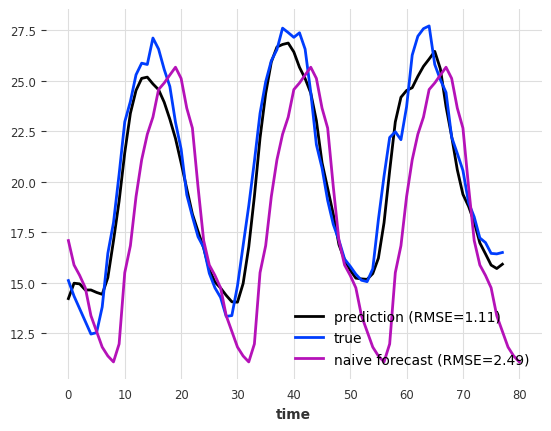

In [54]:
pred = darts.TimeSeries.from_dataframe(pl.DataFrame(y_pred))
true = darts.TimeSeries.from_dataframe(pl.DataFrame(y_test))
baseline = darts.TimeSeries.from_series(seasonal_forecast.to_dataframe().reset_index()["temperature"])
pred.plot(label=f"prediction (RMSE={nn_rmse})")
true.plot(label="true")
baseline.plot(label=f"naive forecast (RMSE={baseline_rmse})");

### Neuronales Netz (Multiple Outputs)

#### Datenvorverarbeitung

Wenn wir mehrschrittig vorhersagen wollen, brauchen wir auch die n Schritte der Zukunft für das Testen.

In [55]:
n_out = 7
cols, names_future = list(), list()
for i in range(n_out - 1, 0, -1):  # n_out-1, da wir temperature schon als ersten Vorhersagestep haben
    cols.append(df["temperature"].shift(-i))  # shift rows back by i to get k+i temperature value
    names_future += [f'temp(t+{i})']

df = pl.concat([df, pl.DataFrame(cols, schema=names_future)], how="horizontal").drop_nans()  # drops n_out rows
df

datetime,temperature,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,temp(t-7),temp(t-6),temp(t-5),temp(t-4),temp(t-3),temp(t-2),temp(t-1),temp(t+6),temp(t+5),temp(t+4),temp(t+3),temp(t+2),temp(t+1)
datetime[μs],f64,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-07-08 22:00:00,16.78,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,0.866025,21.49,20.685,19.93,18.69,17.78,17.31,16.84,15.49,15.71,15.71,15.94,16.275,16.62
2021-07-08 23:00:00,16.62,23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.258819,0.965926,20.685,19.93,18.69,17.78,17.31,16.84,16.78,15.38,15.49,15.71,15.71,15.94,16.275
2021-07-09 00:00:00,16.275,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,19.93,18.69,17.78,17.31,16.84,16.78,16.62,15.395,15.38,15.49,15.71,15.71,15.94
2021-07-09 01:00:00,15.94,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.258819,0.965926,18.69,17.78,17.31,16.84,16.78,16.62,16.275,15.49,15.395,15.38,15.49,15.71,15.71
2021-07-09 02:00:00,15.71,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.866025,17.78,17.31,16.84,16.78,16.62,16.275,15.94,15.595,15.49,15.395,15.38,15.49,15.71
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2021-07-24 18:00:00,24.425,18,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,-1.8370e-16,23.715,26.275,27.21,27.585,27.72,25.81,25.055,17.22,18.26,18.97,20.56,21.405,22.21
2021-07-24 19:00:00,22.21,19,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.965926,0.258819,26.275,27.21,27.585,27.72,25.81,25.055,24.425,16.99,17.22,18.26,18.97,20.56,21.405
2021-07-24 20:00:00,21.405,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.866025,0.5,27.21,27.585,27.72,25.81,25.055,24.425,22.21,16.455,16.99,17.22,18.26,18.97,20.56


In [56]:
n = len(df)
split_idx = train_per*n

# split the whole dataset into train and test
df = df.with_row_index()
df_train = df.filter(pl.col("index") < split_idx).drop("index")
df_test = df.filter(pl.col("index") >= split_idx).drop("index")
df = df.drop("index")

# select features to train on
train_features = names + list(enc_cols_names) + ["hour_sin", "hour_cos"]
X_train = df_train.select(train_features)
X_test = df_test.select(train_features)
print(X_train.shape)
print(X_test.shape)

(308, 16)
(77, 16)


In [57]:
# select target variable
target_variables = ["temperature"] + [f"temp(t+{i})" for i in range(1, n_out)]
y_train = df_train[target_variables]
y_test = df_test[target_variables]
print(y_train.shape)
print(y_test.shape)

(308, 7)
(77, 7)


##### Scaling

In [58]:
X_scaler = StandardScaler()

other_features = list(enc_cols_names) + ["hour_sin", "hour_cos"]
X_train_scaled = pl.concat([
    pl.DataFrame(X_scaler.fit_transform(X_train[names])),
    X_train[other_features]
    ], how="horizontal")
X_test_scaled = pl.concat([pl.DataFrame(X_scaler.transform(X_test[names])),
                           X_test[other_features]], how="horizontal")

In [59]:
y_scaler = StandardScaler()
y_train_scaled = pl.DataFrame(y_scaler.fit_transform(y_train))
y_test_scaled = pl.DataFrame(y_scaler.transform(y_test))

#### Architektur

In [60]:
model = Sequential()
n_features = X_train.shape[1]

model.add(InputLayer(input_shape=(n_features,)))
model.add(Dense(48, activation="relu", kernel_initializer="normal"))
model.add(Dense(n_out, activation="linear"))
model.compile(optimizer="adam", loss="mse", metrics=[rmse])
model.summary()

/home/marja/anaconda3/envs/energy-forecast-wahl/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 48)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,159 (4.53 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=32)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0902 - rmse: 1.0403  
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9160 - rmse: 0.9557 
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7253 - rmse: 0.8514 
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7396 - rmse: 0.8569 
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5987 - rmse: 0.7729 
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5229 - rmse: 0.7223 
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4528 - rmse: 0.6709 
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3503 - rmse: 0.5918 
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3148 - rmse: 0.5594 
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2821 - rmse: 0.5296 
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2498 - rmse: 0.4997 
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2304 - rmse: 0.4783 
Epoch 13/30
10/10 ━━━━━━

#### Evaluation

In [62]:
# RMSE berechnen
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
nn_rmse = np.sqrt(mse).round(2)
print(f"RMSE: {nn_rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
RMSE: 2.03
MSE: 4.1382036209106445
MAE: 1.561481237411499


No time column specified (`time_col=None`) and no index found in the `DataFrame`. Defaulting to `pandas.RangeIndex(len(df))`. If this is not desired consider adding a time column to your `DataFrame` and defining `time_col`.
No time column specified (`time_col=None`) and no index found in the `DataFrame`. Defaulting to `pandas.RangeIndex(len(df))`. If this is not desired consider adding a time column to your `DataFrame` and defining `time_col`.


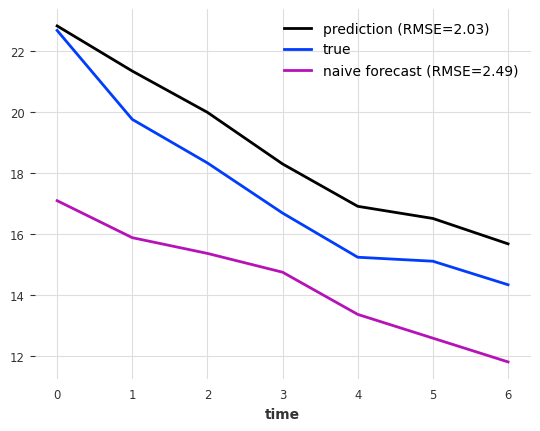

In [63]:
pred = darts.TimeSeries.from_dataframe(pl.DataFrame(y_pred[0]))
true = darts.TimeSeries.from_dataframe(pl.DataFrame(y_test[0].transpose()))
baseline = darts.TimeSeries.from_series(seasonal_forecast.to_dataframe()[:n_out].reset_index()["temperature"])
pred.plot(label=f"prediction (RMSE={nn_rmse})")
true.plot(label="true")
baseline.plot(label=f"naive forecast (RMSE={baseline_rmse})");

### Recurrent Neural Network (darts)

In [64]:
from darts.models import RNNModel

rnn_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.05,
    batch_size=32,
    n_epochs=75,
    input_chunk_length=7,
    training_length=24)

rnn_model.fit(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 1.3 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 74: 100%|██████████| 10/10 [00:00<00:00, 98.62it/s, train_loss=33.40] 

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 74: 100%|██████████| 10/10 [00:00<00:00, 97.30it/s, train_loss=33.40]


RNNModel(model=RNN, hidden_dim=20, n_rnn_layers=2, dropout=0.05, training_length=24, batch_size=32, n_epochs=75, input_chunk_length=7)

Nur, weil das Modell komplexer ist, heißt das nicht, dass die Ergebnisse besser sind. Hier sehen wir die Vorhersage des RNN Modells, welches nur ziemlich gleiche Werte ausgibt. Das liegt höchstwahrscheinlich daran, dass wir viel zu wenige Daten für so ein Modell haben.

In [65]:
pred = rnn_model.predict(n=7, series=train)
pred.values()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.10it/s]


array([[14.4452485 ],
       [14.44505265],
       [14.4450485 ],
       [14.44504841],
       [14.44504841],
       [14.44504841],
       [14.44504841]])

#### Größerer Datensatz

Um ein Beispiel an einem größeren Datensatz zu zeigen, verwenden wir einen von darts bereitgestellten Datensatz, welcher Wetterdaten über einen Zeitraum von einem Jahr pro halbe Stunde aufzeichnet.
Den folgenden Code kann man in der [darts Doku](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html#darts.models.forecasting.rnn_model.RNNModel:~:text=Default%3A%20False.-,Examples,-%3E%3E%3E%20from%20darts) finden.

Number of series components (21) is larger than the maximum number of components to plot (10). Plotting only the first `10` components. You can adjust the number of components to plot using `max_nr_components`.


<Axes: xlabel='Date Time'>

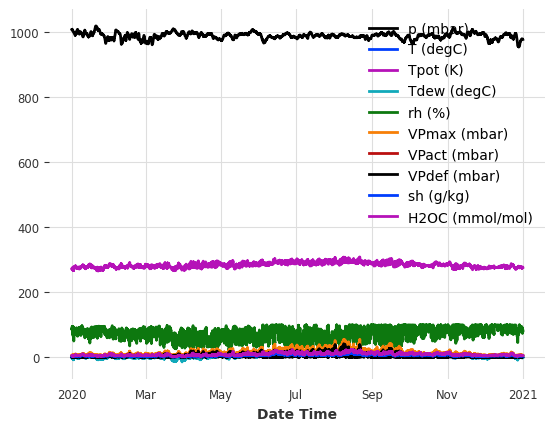

In [66]:
from darts.datasets import WeatherDataset
from darts.models import RNNModel

series = WeatherDataset().load()
series.plot()

Anstatt nur die vorhergegangenen Werte anzugeben, kann man auch Zukunftswerte mit angeben.

In [67]:
# optionally, use future temperatures (pretending this component is a forecast)
target = series['T (degC)'][:1000]  # first thousand values
future_cov = series['VPmax (mbar)'][:1024]  # first thousand + 24 future values

# `training_length` > `input_chunk_length` to mimic inference constraints
model = RNNModel(
    model="RNN",
    input_chunk_length=30,
    training_length=30,
    n_epochs=20,
)
model.fit(target, future_covariates=future_cov)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 725    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
751       Trainable params
0         Non-trainable params
751       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 31/31 [00:00<00:00, 104.68it/s, train_loss=0.0756]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 31/31 [00:00<00:00, 104.18it/s, train_loss=0.0756]


RNNModel(model=RNN, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=30, input_chunk_length=30, n_epochs=20)

In [68]:
pred = model.predict(24)  # vorhersage nach Trainings Zeitreihe
pred.values()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.34it/s]


array([[1.59988141],
       [1.61036055],
       [1.59970366],
       [1.59920089],
       [1.61565046],
       [1.62102544],
       [1.61763558],
       [1.60950786],
       [1.59460645],
       [1.58480635],
       [1.57671527],
       [1.55903328],
       [1.56469344],
       [1.57880052],
       [1.60124716],
       [1.61153209],
       [1.61808372],
       [1.63575766],
       [1.65805355],
       [1.68660108],
       [1.7279111 ],
       [1.76573304],
       [1.80690802],
       [1.838705  ]])

In [69]:
from darts.metrics import rmse, mse, mae

true = series['T (degC)'][:1024][-24:]  # gemessene Temperaturwerte für den Zeitpunkt der Vorhersage
rnn_rmse = rmse(true, pred).round(2)
rnn_mse = mse(true, pred).round(2)
rnn_mae = mae(true, pred).round(2)

print(f"RMSE: {rnn_rmse}")
print(f"MSE: {rnn_mse}")
print(f"MAE: {rnn_mae}")

RMSE: 0.78
MSE: 0.6
MAE: 0.54


<Axes: xlabel='Date Time'>

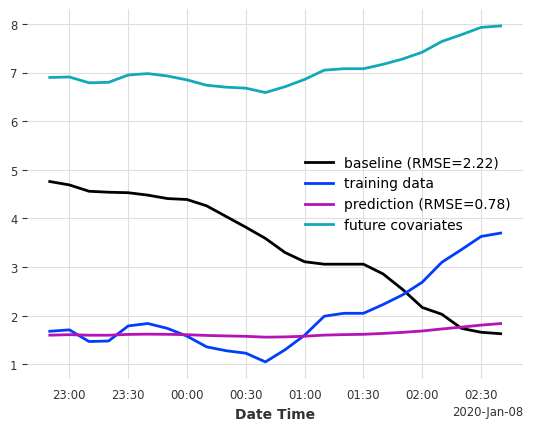

In [70]:
from darts.models import NaiveSeasonal
from darts.metrics import rmse

true = series['T (degC)'][:1024][-24:]
seasonal_model = NaiveSeasonal(K=24)
seasonal_model.fit(target)
seasonal_forecast = seasonal_model.predict(24)
baseline_rnn_rmse = rmse(true, seasonal_forecast).round(2)

seasonal_forecast.plot(label=f"baseline (RMSE={baseline_rnn_rmse})");
true.plot(label="training data")
pred.plot(label=f"prediction (RMSE={rnn_rmse})")
future_cov[-24:].plot(label="future covariates")